In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

5.1

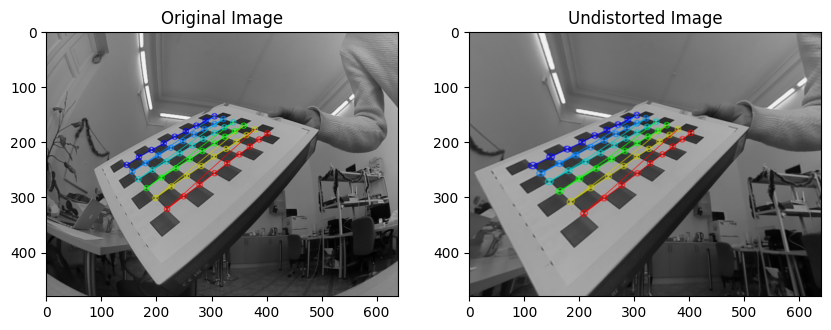

In [6]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW

width = 9
heigth = 6
square_size = 0.025

objp = np.zeros((heigth * width, 1, 3), np.float64)
objp[:, 0, :2] = np.mgrid[0:width, 0:heigth].T.reshape(-1, 2)

objp = objp * square_size

objpoints = []
imgpoints = []
img_width = 640
img_height = 480

number_of_images = 50
for i in range(1, number_of_images):
    img = cv2.imread('pairs/left_%02d.png' % i)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (width, heigth), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    Y, X, channels = img.shape

    if ret:
        minRx = corners[:, :, 0].min()
        maxRx = corners[:, :, 0].max()
        minRy = corners[:, :, 1].min()
        maxRy = corners[:, :, 1].max()

        border_threshold_x = X / 12
        border_threshold_y = Y / 12

        x_thresh_bad = False
        if minRx < border_threshold_x:
            x_thresh_bad = True
            
        y_thresh_bad = False
        if minRy < border_threshold_y:
            y_thresh_bad = True

        if y_thresh_bad or x_thresh_bad:
            continue

    if ret:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)

        imgpoints.append(corners2)

        cv2.drawChessboardCorners(img, (width, heigth), corners2, ret)
        cv2.imshow('corners', img)
        cv2.waitKey(100)
cv2.destroyAllWindows()
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

ret, K, D, _, _ = cv2.fisheye.calibrate(objpoints, imgpoints, (img_width, img_height), K, D, rvecs, tvecs, calibration_flags, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))

map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, (img_width, img_height), cv2.CV_16SC2)
undistorted_image = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(undistorted_image)
plt.title('Undistorted Image')
plt.show()

for i in range(1, number_of_images):
    img = cv2.imread('pairs/left_%02d.png' % i)
    undistorted_image = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    cv2.imshow('undistorted', undistorted_image)
    cv2.waitKey(100)
cv2.destroyAllWindows()

5.2

In [9]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW

width = 9
heigth = 6
square_size = 0.025

objp = np.zeros((heigth * width, 1, 3), np.float64)
objp[:, 0, :2] = np.mgrid[0:width, 0:heigth].T.reshape(-1, 2)

objp = objp * square_size

objpoints = []
imgpoints_left = []
imgpoints_right = [] 
for i in range(1, number_of_images):
    img_left = cv2.imread('pairs/left_%02d.png' % i)
    gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)

    img_right = cv2.imread('pairs/right_%02d.png' % i)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    ret_left, corners_left = cv2.findChessboardCorners(gray_left, (width, heigth), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    ret_right, corners_right = cv2.findChessboardCorners(gray_right, (width, heigth), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    if ret_left and ret_right:
        objpoints.append(objp)

        corners2_left = cv2.cornerSubPix(gray_left, corners_left, (3, 3), (-1, -1), criteria)
        imgpoints_left.append(corners2_left)
        corners2_right = cv2.cornerSubPix(gray_right, corners_right, (3, 3), (-1, -1), criteria)
        imgpoints_right.append(corners2_right)

        cv2.drawChessboardCorners(img_left, (width, heigth), corners2_left, ret_left)
        cv2.drawChessboardCorners(img_right, (width, heigth), corners2_right, ret_right)

        cv2.imshow('corners_left', img_left)
        cv2.imshow('corners_right', img_right)
        cv2.waitKey(100)
cv2.destroyAllWindows()
N_OK = len(objpoints)
K_left = np.zeros((3, 3))
D_left = np.zeros((4, 1))
K_right = np.zeros((3, 3))
D_right = np.zeros((4, 1))
rvecs_left = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
rvecs_right = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs_left = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs_right = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

ret_left, K_left, D_left, _, _ = cv2.fisheye.calibrate(objpoints, imgpoints_left, (img_width, img_height), K_left, D_left, rvecs_left, tvecs_left, calibration_flags, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))

ret_right, K_right, D_right, _, _ = cv2.fisheye.calibrate(objpoints, imgpoints_right, (img_width, img_height), K_right, D_right, rvecs_right, tvecs_right, calibration_flags, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))

map1_right, map2_right = cv2.fisheye.initUndistortRectifyMap(K_right, D_right, np.eye(3), K_right, (img_width, img_height), cv2.CV_16SC2)
map1_left, map2_left = cv2.fisheye.initUndistortRectifyMap(K_left, D_left, np.eye(3), K_left, (img_width, img_height), cv2.CV_16SC2)
imgpoints_left = np.asarray(imgpoints_left, dtype=np.float64)
imgpoints_right = np.asarray(imgpoints_right, dtype=np.float64)

RMS, _, _, _, _, rotation_matrix, translation_vector = cv2.fisheye.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, K_left, D_left, K_right, D_right, (img_width, img_height), None, None, cv2.CALIB_FIX_INTRINSIC, criteria)
R2 = np.zeros((3, 3))
P1 = np.zeros((3, 4))
P2 = np.zeros((3, 4))
Q = np.zeros((4, 4))

left_rectification, right_rectification, left_projection, right_projection, dispartity_to_depth_map = cv2.fisheye.stereoRectify(K_left, D_left, K_right, D_right, (img_width, img_height), rotation_matrix, translation_vector, 0, R2, P1, P2, Q, cv2.CALIB_ZERO_DISPARITY, (0, 0),0 ,0)
map1_left, map2_left = cv2.fisheye.initUndistortRectifyMap(K_left, D_left, left_rectification, left_projection, (img_width, img_height), cv2.CV_16SC2)

map1_right, map2_right = cv2.fisheye.initUndistortRectifyMap(K_right, D_right, right_rectification, right_projection, (img_width, img_height), cv2.CV_16SC2)
dst_left = cv2.remap(img_left, map1_left, map2_left, interpolation=cv2.INTER_LINEAR)
dst_right = cv2.remap(img_right, map1_right, map2_right, interpolation=cv2.INTER_LINEAR)
N, XX, YY = dst_left.shape[::-1]

visRectify = np.zeros((YY, XX * 2, 3), np.uint8)
visRectify[:, :XX, :] = dst_left
visRectify[:, XX:, :] = dst_right

for y in range(0, YY, 10):
    cv2.line(visRectify, (0, y), (2 * XX, y), (255, 0, 0))

cv2.imshow('visRectify', visRectify)
cv2.waitKey(0)
cv2.destroyAllWindows()

5.3

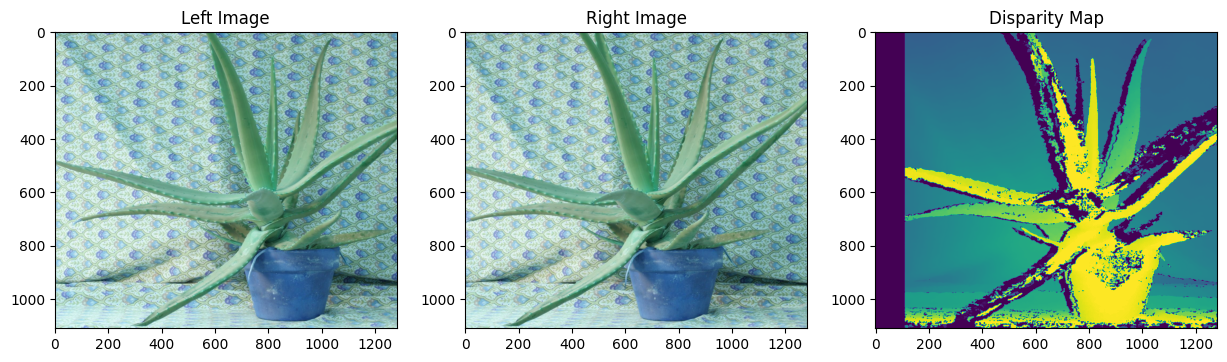

In [8]:
aloes_left = cv2.imread('aloes/aloeL.jpg')
aloes_right = cv2.imread('aloes/aloeR.jpg')
window_size = 6
min_disp = 16
num_disp = 112 - min_disp
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=4,
    P1=8 * 3 * window_size ** 2,
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
    )

disp = stereo.compute(aloes_left, aloes_right).astype(np.float32) / 16.0

plt.subplots(1, 3, figsize=(15, 5))
plt.subplot(131)
plt.imshow(aloes_left)
plt.title('Left Image')
plt.subplot(132)
plt.imshow(aloes_right)
plt.title('Right Image')
plt.subplot(133)
plt.imshow(disp)
plt.title('Disparity Map')
plt.show()